In [207]:
using Base.Threads
using LinearAlgebra
using Images
using Random
using Statistics
using MAT
using DelimitedFiles
using Plots


FUNCTION FOR CALCULATING PSNR

In [208]:
function PSNR(im, im_ref, max_val = 1)
    N=length(im);
    MSE=(1/N)*sum((im_ref-im).^2);
    ratio=10*log10((max_val^2)/MSE);
    return ratio
end

PSNR (generic function with 2 methods)

PATCH EXTRACTION

In [209]:
#this functions gets an image as input and return the Patch matrix (each row is a patch from the input image)
function im2patch(im, L)
    M = size(im,1)
    N = size(im,2)
    #im_pad = [zeros(L, N); im; zeros(L, N)];
    #im_pad = [zeros(M+2*L, L) im_pad zeros(M+2*L, L)];
	im_pad = [ones(L)*im[1,:]'; im; ones(L)*im[end,:]'];
	im_pad = [im_pad[:,1]*ones(1,L) im_pad im_pad[:,end]*ones(1,L)];
    n_patches = M*N;
    P = zeros(typeof(im[1,1]),n_patches, (2*L+1)^2);
    cont = 0;
    for j in 1+L:N+L
        for i in 1+L:M+L
            patch = im_pad[i-L:i+L, j-L:j+L];
            cont = cont+1
            P[cont, :] = vec(patch);
        end
    end
    return P
end

im2patch (generic function with 1 method)

NEAREST NEIGHBOR QUERIES

In [210]:
mutable struct Arvore 
 B::Array{Bool} 
 Variavel::Array{Int} 
 Limiar::Array{Float64}
 Prefixo::Dict
 Folha::Dict
end


function quantRapido(X,C)
    N,Dim=size(X);
    log2C = Int(round(log2(C)));
    B=zeros(Bool,N,log2C);
    Variavel = [];
    Limiar = [];
    Prefixo = Dict();
    Folha = Dict();

    coluna=1;
    apontador=collect(1:N);
    media = sum(X[apontador,:],dims=1)/length(apontador);
    ener = sum(X[apontador,:].^2,dims=1)/length(apontador);
    var = ener .- media.^2;
    selecao = argmax(var[:]);
    push!(Variavel, selecao);
    pos=sortperm(X[apontador,selecao]);
    pMediano = Int(floor(length(pos)/2));
    push!(Limiar, X[apontador[pos[pMediano]],selecao]);
    #B[apontador[pos[1:pMediano]],coluna] .= false;
    B[apontador[pos[pMediano+1:end]],coluna] .= true;
    for coluna=2:log2C
        U=unique(B,dims=1);
        for k in 1:size(U,1)
            apontador=findall(sum(B .== ones(N)*U[k,:]',dims=2)[:] .== size(U,2));
            media = sum(X[apontador,:],dims=1)/length(apontador);
            ener = sum(X[apontador,:].^2,dims=1)/length(apontador);
            var = ener .- media.^2;
            selecao = argmax(var[:]);
            push!(Variavel, selecao);
            pos=sortperm(X[apontador,selecao]);
            pMediano = Int(floor(length(pos)/2));
            if pMediano != 0
                push!(Limiar, X[apontador[pos[pMediano]],selecao]);
                #B[apontador[pos[1:pMediano]],coluna] .= false;
                B[apontador[pos[pMediano+1:end]],coluna] .= true;
                Prefixo[U[k,1:coluna-1]]=length(Limiar);
            end
        end
    end
    U=unique(B,dims=1);
    for k in 1:size(U,1)
      posMesmo = findall(sum(B .== ones(size(B,1))*U[k,:]',dims=2)[:] .== size(B,2));
      Folha[U[k,:]] = posMesmo;
    end
    arvore = Arvore(B,Variavel,Limiar,Prefixo,Folha);

    return arvore
end

function achaViz(x,K,X,arvore)
    log2C = size(arvore.B,2);
    b=zeros(Bool,log2C);
    b[1] = x[arvore.Variavel[1]] > arvore.Limiar[1];
    for coluna in 2:log2C
        apontador = arvore.Prefixo[b[1:coluna-1]];
        b[coluna] = x[arvore.Variavel[apontador]] > arvore.Limiar[apontador];
    end
    
    posMesmo = arvore.Folha[b];
    #d2 = sum((X[posMesmo,:] - ones(length(posMesmo))*x').^2,dims=2);
    dSup = maximum(abs.(X[posMesmo,:] - ones(length(posMesmo))*x'),dims=2);
    # MX2 = sum(X[posMesmo,:].^2,dims=2);
    # Mx2 = sum(x.^2);
    # uX = X[posMesmo,:]./sqrt.(MX2*ones(1,size(X,2)));
    # ux = x/sqrt(Mx2);
    # dCos = 1 .- uX*ux;

    pp = sortperm(dSup[:]);
    #pp = sortperm(dCos[:]);
    K = minimum([K,length(posMesmo)]);
    knn = posMesmo[pp[2:K+1]];
    #dnn = sqrt.(d2[pp[1:K]]);
    dnn = dSup[pp[2:K+1]];
    #dnn = dCos[pp[2:K+1]];
    
    return knn,dnn
end



achaViz (generic function with 1 method)

FUNCTIONS FOR DOWNSAMPLING AND UPSAMPLING

In [211]:
function max_pooling(im) #downscaling
    M = size(im,1)
    N = size(im,2)
    px = collect(1:2:M)
    py = collect(1:2:N)
    im_down = []
    for j in py
        for i in px
            patch  = im[i:i+1, j:j+1]
            pixel = maximum(patch)
            push!(im_down, pixel)
        end
    end
    im_down = reshape(im_down, Int(M/2), Int(N/2))
    return im_down
end

function upscaling(X,S,fk) #X is the image in the coarser level, S is the image in the finer level and fk are the flags in the finer level (routine for upscaling)
    M,N=size(fk);
    Xaux = zeros(M,N);
    for m in 1:M
        for n in 1:N
            if fk[m,n] == 1
                Xaux[m,n] = S[m,n];
            else
                ma = Int(ceil(m/2));
                na = Int(ceil(n/2));
                Xaux[m,n] = X[ma,na];
            end
        end
    end
    return Xaux
end

upscaling (generic function with 1 method)

DIFFUSION (SINGLE SCALE)

In [212]:
function one_iter(X0, F0, P_F, L, delta_NN, Knn, phi) #SINGLE ITERATION
    P = im2patch(X0, L)
    M, N = size(X0)
    row_of_P = 1
    CC=Int(floor(size(P,1)/50))
    arvore  = quantRapido(P,CC) 
    new_X0 = copy(X0)
    center = Int(((2*L+1)^2+1)/2)

    @threads for j in 1:N
        for i in 1:M
            if F0[i,j] == 0
                #knn,dnn = achaViz(P[(j-1)*M+i,:],Knn,P,B_quant,Pref_quant,Var_quant,Lim_quant)
                knn,dnn = achaViz(P[(j-1)*M+i,:],Knn,P,arvore)
                C = P[knn,:]
                if sum(dnn.<=delta_NN)>0 
                    C = C[dnn.<=delta_NN,:]
                    f = P_F[(j-1)*M+i,:]
                    D = Diagonal(abs.(f.-phi))
                    #p_hat = C'*inv(C*D*C'+1e-6*Diagonal(ones(size(C,1))))*C*D*P[(j-1)*M+i,:]
                    A = C*D*C'+1e-6*Diagonal(ones(size(C,1)))
                    b = C*D*P[(j-1)*M+i,:]
                    aux = A\b 
                    p_hat = C'*aux
                    new_X0[i,j] = 0.5*(X0[i,j]+p_hat[center]);
                end
            end
        end
    end
    return new_X0
end

function diffusion(X_init, F0, L, delta_NN, Knn, phi, num_iter, X_truth) #full process in a single scale
    X0 = copy(X_init)
    P_F = im2patch(F0, L)
    metrics = zeros(num_iter)
    for iter in 1:num_iter
        X0 = one_iter(X0, F0, P_F, L, delta_NN, Knn, phi)
        metrics[iter] = PSNR(X0, X_truth)
        println(iter)
        println("PSNR:", metrics[iter])
    end
    return X0, metrics
end


diffusion (generic function with 1 method)

10% SUBSAMPLING

In [214]:
#lOADING MASK 
vars = matread("data_barbara_10.mat");
F0 = vars["mask"];
F0 = Int.(F0).+0.0


#LOADING IMAGE

X = load("images//barbara_256.png");
X = Gray.(X);
X = Float64.(X);
L = 8 
delta_NN = 0.7
Knn = 20
phi = 0.2;

#=
X = load("images//boat_256.png");
X = Gray.(X);
X = Float64.(X);
L = 5
delta_NN = 0.5
Knn = 20
phi = 0.25;=#

#=
X = load("images//couple_256.png");
X = Gray.(X);
X = Float64.(X);
L = 5
delta_NN = 0.5
Knn = 20
phi = 0.15;=#

#=X = load("images//checkerboard_256.jpg");
X = Gray.(X);
X = Float64.(X);
L = 5
delta_NN = 0.7
Knn = 40
phi = 0.1;=#

#=X = load("images//fingerprint_256.png");
X = Gray.(X);
X = Float64.(X);
L = 3
delta_NN = 0.5
Knn = 20
phi = 0.15;=#

#=X = load("images//man_256.png");
X = Gray.(X);
X = Float64.(X);
L = 5
delta_NN = 0.5
Knn = 20
phi = 0.2;=#

#=
X = load("images//hill_256.png");
X = Gray.(X);
X = Float64.(X);
L = 5
delta_NN = 0.5
Knn = 25
phi = 0.2;=#

#=X = load("images//house.png");
X = Gray.(X);
X = Float64.(X);
L = 4
delta_NN = 0.5
Knn = 20
phi = 0.15;=#

#=
X = load("images//swirl2_256.png");
X = Gray.(X);
X = Float64.(X);
L = 4
delta_NN = 0.5
Knn = 20
phi = 0.15;=#





50% SUBSAMPLING

In [215]:
#lOADING MASK 
#F0 = readdlm("mask_50.txt")


#LOADING IMAGE

#=
X = load("images//barbara_256.png");
X = Gray.(X);
X = Float64.(X);
L = 3
delta_NN = 0.5
Knn = 40
phi = 0.15;=#

#=
X = load("images//boat_256.png");
X = Gray.(X);
X = Float64.(X);
L = 3
delta_NN = 0.5
Knn = 25
phi = 0.25;=#

#=
X = load("images//couple_256.png");
X = Gray.(X);
X = Float64.(X);
L = 2
delta_NN = 0.5
Knn = 15
phi = 0.35;=#

#=
X = load("images//checkerboard_256.jpg");
X = Gray.(X);
X = Float64.(X);
L = 3
delta_NN = 0.5
Knn = 10
phi = 0.2;=#

#=
X = load("images//fingerprint_256.png");
X = Gray.(X);
X = Float64.(X);
L = 4
delta_NN = 0.5
Knn = 58
phi = 0.2;=#

#=
X = load("images//man_256.png");
X = Gray.(X);
X = Float64.(X);
L = 3
delta_NN = 0.5
Knn = 35
phi = 0.25;=#


#=X = load("images//hill_256.png");
X = Gray.(X);
X = Float64.(X);
L = 4
delta_NN = 0.5
Knn = 35
phi = 0.31;=#

#=
X = load("images//house.png");
X = Gray.(X);
X = Float64.(X);
L = 3
delta_NN = 0.5
Knn = 25
phi = 0.2;=#

#=
X = load("images//swirl2_256.png");
X = Gray.(X);
X = Float64.(X);
L = 2
delta_NN = 0.5
Knn = 20
phi = 0.2;=#





In [216]:
m = X.*F0 
X_truth = copy(X)

#down_sampling
X_truth_lev1 = max_pooling(X_truth)
X_truth_lev2 = max_pooling(X_truth_lev1)
X_truth_lev3 = max_pooling(X_truth_lev2)

m_lev1 = max_pooling(m)
m_lev2 = max_pooling(m_lev1)
m_lev3 = max_pooling(m_lev2)

F0_lev1 = max_pooling(F0)
F0_lev2 = max_pooling(F0_lev1)
F0_lev3 = max_pooling(F0_lev2)


#MULTISCALE RECONSTRUCTION

#initialization at level 3
aux = vec(m_lev3)[vec(m_lev3).!=0];
complete = (std(aux)*randn(32,32).+mean(aux)).*(F0_lev3.==0);
X_init_lev3 = m_lev3+complete

println("Reconstruction at level 3")
X_rec_lev3, metrics_lev3 = diffusion(X_init_lev3, F0_lev3, 1, delta_NN, Knn, phi, 100, X_truth_lev3)

X_init_lev2 = upscaling(X_rec_lev3, m_lev2, F0_lev2)

println("Reconstruction at level 2")
X_rec_lev2, metrics_lev2 = diffusion(X_init_lev2, F0_lev2, 2, delta_NN, Knn, phi, 1, X_truth_lev2)

X_init_lev1 = upscaling(X_rec_lev2, m_lev1, F0_lev1)

println("Reconstruction at level 1")
X_rec_lev1, metrics_lev1 = diffusion(X_init_lev1, F0_lev1, 3, delta_NN, Knn, phi, 30, X_truth_lev1)

X_init = upscaling(X_rec_lev1, m, F0)

println("Reconstruction at level 0")
X_rec, metrics = diffusion(X_init, F0, L, delta_NN, Knn, phi, 100, X_truth)

Reconstruction at level 3
1
PSNR:21.408736268462143
2
PSNR:21.40875055732373
3
PSNR:21.408764842135106
4
PSNR:21.40877912289769
5
PSNR:21.40879339961291
6
PSNR:21.408807672282187
7
PSNR:21.40882194090694
8
PSNR:21.408836205488594
9
PSNR:21.40885046602857
10
PSNR:21.40886472252829
11
PSNR:21.408878974989168
12
PSNR:21.408893223412626
13
PSNR:21.408907467800088
14
PSNR:21.408921708152967
15
PSNR:21.408935944472674
16
PSNR:21.408950176760648
17
PSNR:21.40896440501828
18
PSNR:21.40897862924701
19
PSNR:21.40899284944824
20
PSNR:21.40900706562338
21
PSNR:21.40902127777386
22
PSNR:21.409035485901093
23
PSNR:21.40904969000648
24
PSNR:21.409063890091446
25
PSNR:21.409078086157397
26
PSNR:21.40909227820575
27
PSNR:21.409106466237912
28
PSNR:21.4091206502553
29
PSNR:21.409134830259326
30
PSNR:21.409149006251393
31
PSNR:21.409163178232916
32
PSNR:21.409177346205297
33
PSNR:21.409191510169954
34
PSNR:21.409205670128294
35
PSNR:21.409219826081717
36
PSNR:21.40923397803164
37
PSNR:21.409248125979467


([0.403921568627451 0.4033974982584898 … 0.34921751477725216 0.3655073916275675; 0.4027508614524631 0.4021816661791021 … 0.35440323452529465 0.38300392108807185; … ; 0.6788136791624277 0.6745098039215687 … 0.5364716280961899 0.5383588376132888; 0.6784313725490196 0.6754083135373967 … 0.5379911034237908 0.53734831950488], [22.492913722981708, 22.72096506176062, 22.882205805346175, 23.006058862488775, 23.115987978213617, 23.203949689761583, 23.298776780380987, 23.37331985990806, 23.439967304487567, 23.515426042651608  …  24.88343713608667, 24.901715759946725, 24.90637611604306, 24.92265112752129, 24.918175129719728, 24.913876610421784, 24.91320950487558, 24.92091014449909, 24.91363548711086, 24.915731384288154])

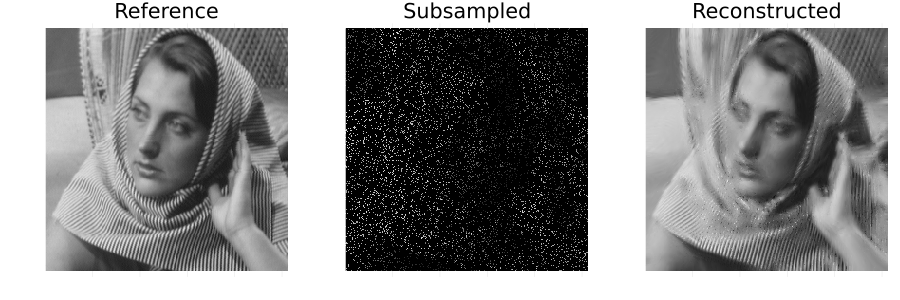

In [217]:
X1 = Gray.(X_truth)
X2 = Gray.(m)
X3 = Gray.(X_rec)

plot(
    heatmap(X1, color=:grays, axis=false, colorbar=false, yflip=true, title= "Reference"),
    heatmap(X2, color=:grays, axis=false, colorbar=false, yflip=true, title= "Subsampled"),
    heatmap(X3, color=:grays, axis=false, colorbar=false, yflip=true, title= "Reconstructed"),
    layout=(1,3), size=(900,300)
)

In [219]:
savefig("results_10pct//barbara_comparison.png")

"/home/jugurta/results_10pct/barbara_comparison.png"

In [220]:
writedlm("results_10pct//barbara_result.txt", X_rec)

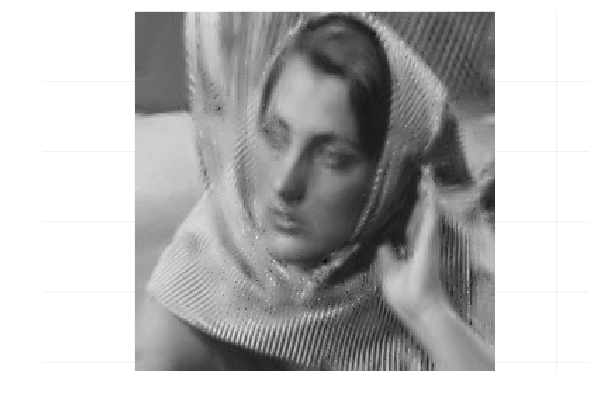

In [218]:
heatmap(X3, color=:grays, axis=false, colorbar=false, yflip=true)

In [206]:
savefig("results_10pct//barbara_result.png")

"/home/jugurta/results_50pct/swirl_result.png"